In [ ]:
from google.colab import drive
import os
drive.mount('/gdrive')
os.getcwd()
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

Mounted at /gdrive


'/content'

In [ ]:
root = "/gdrive/My Drive/CS470/cs470_music_generator"
root_data = '/gdrive/My Drive/CS470/data'
root_midi = '/gdrive/My Drive/CS470/data/midi'
os.chdir(root)
os.getcwd()

'/gdrive/My Drive/CS470/cs470_music_generator'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import re
import pickle
import random

In [ ]:
def word_encode(words_arr, word):
    return (words_arr == word).astype(np.float).reshape(1,-1)

def word_mapping(words_arr, word):
    return words_arr[word]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, embed):
        super(Model,self).__init__()

        self.embed = embed
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.input_size = input_size
        
        self.cell = nn.GRU(input_size=hidden_size if embed else input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True)
        
        self.fc = nn.Linear(hidden_size,output_size)
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        
    def forward(self,input):
        batch_size = input.size()[0]
        hidden = self._init_hidden(batch_size)
        if self.embed:
            x_ = self.encoder(input)
        else:
            x_ = input
        output, hidden = self.cell(x_, hidden)
        fc_output = self.fc(output.view(-1, hidden_size))
        return fc_output
    
    def forward2(self, input, hidden):
        if self.embed:
            x_ = self.encoder(input)
        else:
            x_ = input
        output,hidden = self.cell(x_,hidden)
        fc_output = self.fc(output.view(-1, hidden_size))
        return fc_output, hidden
    
    def _init_hidden(self,batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return hidden

In [ ]:
lines = list(map(lambda x: x.strip(), open("data/cleaned_lyrics.txt").readlines()))
lines = '\n'.join(lines)
words_arr = np.array(list(set(re.findall(r'\S+|\n', lines))))
n_words = len(words_arr)

In [ ]:
input_size = n_words
hidden_size = 256 
num_layers = 1
output_size = n_words

lyrics_model = Model(input_size, hidden_size, num_layers, output_size, False).to(device)

lyrics_model

Model(
  (cell): GRU(4405, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=4405, bias=True)
  (encoder): Embedding(4405, 256)
)

In [ ]:
!git clone https://github.com/bearpelican/musicautobot.git
os.chdir('musicautobot')
os.getcwd()

fatal: destination path 'musicautobot' already exists and is not an empty directory.


'/gdrive/My Drive/CS470/cs470_music_generator/musicautobot'

In [ ]:
!apt-get update
!apt install musescore fluidsynth
!pip install torch fastai music21 pebble fluidsynth midi2audio

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Pa

In [ ]:
from musicautobot.numpy_encode import *
from musicautobot.config import *
from musicautobot.music_transformer import *
from musicautobot.multitask_transformer import *
from musicautobot.utils import midifile

os.chdir('..')
os.getcwd()

'/gdrive/My Drive/CS470/cs470_music_generator'

In [ ]:
with open("data/dataset_np.pkl", "rb") as fd:
  music_data = pickle.load(fd)

with open("data/music_vocab.pkl", "rb") as fd:
  music_vocab = pickle.load(fd)
  
train_data = list(map(lambda x: x["np"], music_data))
X_train = np.concatenate(train_data, axis=0)
music_arr = np.array(list(set(X_train)))
n_characters = len(music_arr)

In [ ]:
def plot_music(x):
  npenc = idxenc2npenc(x, music_vocab)
  item = MusicItem.from_npenc(npenc, music_vocab)
  item.show()
  return item

In [ ]:
embed = False
transformer = False

input_size = n_characters
hidden_size = 64 if embed else 256 
num_layers = 1 # one-layer rnn
output_size = n_characters
batch_size = 8
input_size

if transformer:
  music_model = nn.Transformer(d_model=n_characters, nhead=13, num_encoder_layers=1, num_decoder_layers=1).to(device)
else:
  music_model = Model(input_size, hidden_size, num_layers, output_size, embed).to(device)

music_model

Model(
  (cell): GRU(169, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=169, bias=True)
  (encoder): Embedding(169, 256)
)

In [ ]:
def generate(model, max_n=None, max_tokens=300, temperature=0.7, top_k=32, arr=None, embed=None, lyrics=False):
    text = []
    letter = random.randint(0, max_n)  
    if embed:
      letter = [letter]
    if lyrics:
      letter = [word_mapping(arr, letter)]
    if type(letter) == list:
      text.append(letter[0])
    else:
      text.append(word_mapping(arr, letter) if lyrics else letter)
    hidden = model._init_hidden(1)
    with torch.no_grad():
        for i in range(max_tokens):
          tmp = word_encode(arr, letter)
          if embed:
            letter, hidden = model.forward2(torch.LongTensor(np.argmax(tmp, axis=1)).unsqueeze(0).to(device), hidden)
          else:
            letter, hidden = model.forward2(torch.FloatTensor(tmp).unsqueeze(0).to(device), hidden)
          if (i+1)%2 == 0:
              letter = arr[torch.multinomial(F.softmax(letter.view(1,-1)),1)]
          else:
              letter = arr[letter.view(1,-1).argmax(1)]
          text.append(letter)
    if embed:
      tmp = [i if type(i) != list else i[0] for i in text]
      text = tmp
    return text

In [ ]:
music_model = torch.load("models/model_music1.pt")
lyrics_model = torch.load("models/model_lyrics1.pt")

In [ ]:
with open("data/words_arr.pkl", "br") as fd:
  words_arr = pickle.load(fd)

with open("data/music_arr.pkl", "br") as fd:
  music_arr = pickle.load(fd)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


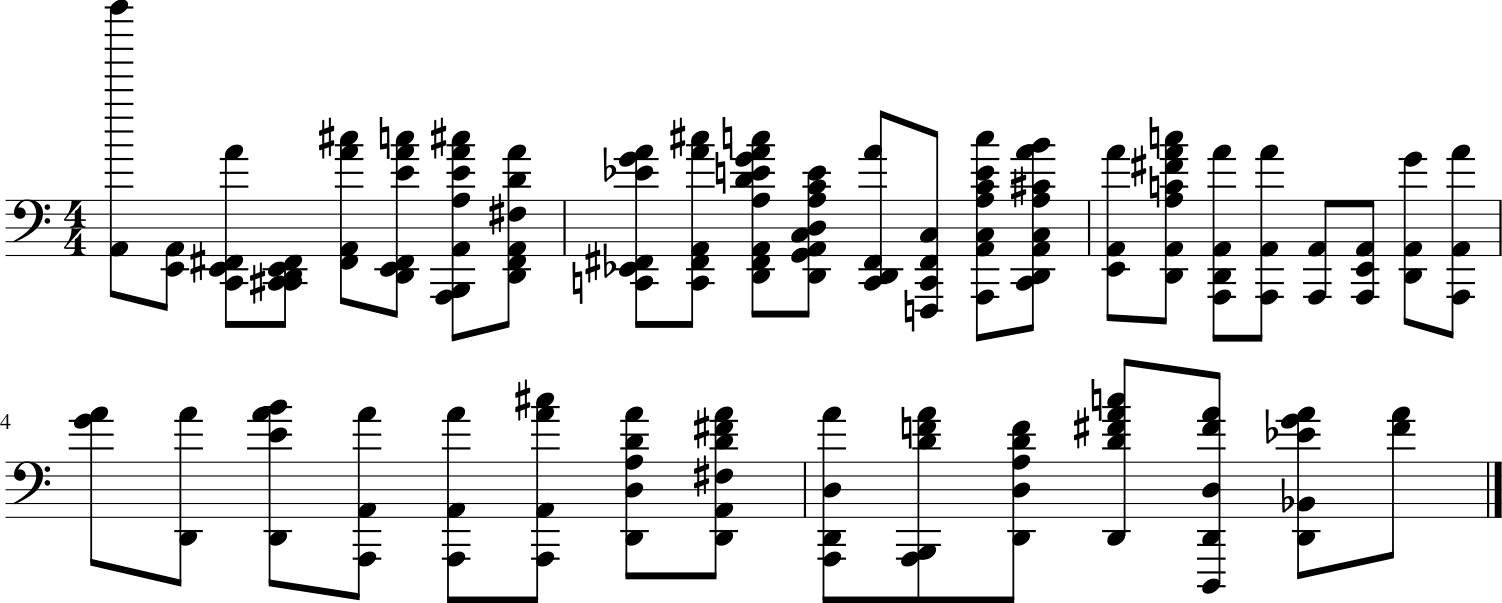

earth to me but ive got something to say 
 just like that love was one 
 to each other by love 
 to each other by love 
 whoever knew that we too could be free as we fancied 
 fancy is free but are you are queen 
 we will it to be sad 
 and i will take her out tonight 
 and i will treat her kind 
 dont you realise its all right 
 oh yeah 
 cant do that you cant rock it like this 
 you cant get it with you 
 cause the night you 
 was a man from the motor trade 
 she what did we do that was wrong 
 is having we didnt know it was wrong 
 fun fun is the one thing want to find the more 
 its gonna be a drag misery 
 ill let you dance with you 
 you know the name love 
 taxman 
 click my finger 
 shes in your hands off your fingers 
 you dont know how lucky you are boy 
 ooh 
 ooh 
 aw 
 run and tell your mama 
 i want you to


In [ ]:
lyrics_length = 500

output = generate(music_model, max_n=n_characters, max_tokens=lyrics_length, arr=music_arr, embed=embed)
item = plot_music(np.array(output))

output = generate(lyrics_model, max_n=n_words, max_tokens=200, arr=words_arr, embed=False, lyrics=True)
print(' '.join(output))

In [ ]:
item.stream.write('midi', fp='music/song2.midi')

'music/song2.midi'

In [ ]:
lyrics = []
for _ in range(0, 25):
  try:
    output = generate(lyrics_model, max_n=n_words, max_tokens=200, arr=words_arr, embed=False, lyrics=True)
    l = ' '.join(output)
    lyrics.append(l)
  except:
    print("Skip")
len(lyrics), lyrics

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(25,
 ['woooooh baby \n some fun tonight \n well were going to have some fun tonight \n have some fun tonight \n everythings alright \n have some fun tonight \n yeah well have some fun some fun tonight \n i been told when a boy kiss a girl \n take a trip around the world \n hey hey \n bop shuop mbop bop shuop \n hey hey bop shuop mbop bop shuop \n hey hey bop shuop mbop bop shuop \n hey hey bop shuop \n yeah she say you do \n bop shuop \n yeah she say you do \n bop shuop \n well i talk about boys \n yeah yeah boys \n dont ya know i mean boys \n yeah yeah boys \n well i talk about boys now \n yeah i mean you do \n yeah yeah boys \n well i talk about boys now \n yeah yeah boys \n aaah boys \n yeah yeah boys \n well i talk about boys now yeah yeah boys \n aaah boys \n yeah yeah boys \n well i talk about boys now \n yeah yeah boys \n aaah boys \n yeah yeah boys \n well i talk about boys now \n',
  'made me cry \n im sorry that i doubted you i was so unfair \n you i find you in my car \n i 

In [ ]:
with open("data/generated.pkl", "wb") as fd:
  pickle.dump(lyrics, fd)

In [ ]:
#your lyrics is generated in "data/last_generated.pkl"
for _ in range(5):
  try:
    output = generate(lyrics_model, max_n=n_words, max_tokens=200, arr=words_arr, embed=False, lyrics=True)
    lyrics = ' '.join(output)
    break
  except:
    print("Skip")
with open("data/last_generated.pkl", "wb") as fd:
  pickle.dump(lyrics, fd)
len(lyrics), lyrics